In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import io
import itertools
import io
import PIL.Image
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# Load the dataset
df = pd.read_csv("data/Top_12_German_Companies_Financial_Data.csv")
companies = np.unique(df.Company)
company = companies[10]
print(f"Company: {company}")
# Filter for SAP SE
df = df[df["Company"] == company].copy()
df["Period"] = pd.to_datetime(df["Period"], format="%m/%d/%Y")
df = df.sort_values(by="Period")
df.set_index("Period", inplace=True)
df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
series = df['Revenue']

Company: Siemens AG


In [3]:
# Train-validation-test split
train_idx = int(len(series) * 0.8)
val_idx = int(len(series) * 0.9)
train, val, test = series[:train_idx], series[train_idx:val_idx], series[val_idx:]

In [4]:
# Define parameter ranges for SARIMA tuning
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
S = 12  # Quarterly seasonality

best_score, best_cfg = float("inf"), None

# Grid search over SARIMA parameter combinations
for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(val))
        error = mean_absolute_error(val, predictions)
        if error < best_score:
            best_score, best_cfg = error, (p, d, q, P, D, Q)
    except:
        continue
# Train best SARIMA model
best_p, best_d, best_q, best_P, best_D, best_Q = best_cfg
final_model = SARIMAX(pd.concat([train, val]), order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, S), enforce_stationarity=False, enforce_invertibility=False)
final_model_fit = final_model.fit(disp=False)

/opt/conda/envs/ai_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/ai_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/ai_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/envs/ai_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/ai_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No freq

In [5]:
def forecast_turnover(horizon):
    try:
        horizon = int(horizon)
        predictions_result = final_model_fit.get_forecast(steps=horizon)
        final_predictions = predictions_result.predicted_mean
        conf_int = predictions_result.conf_int()
        last_date = test.index.min()
        future_dates = pd.date_range(start=last_date, periods=horizon, freq="Q")

        debug_info = f"""
        ✅ Forecast for {horizon} quarters.
        Horizon: {horizon}
        Last Date in Training Data: {last_date}
        Future Dates: {future_dates}
        Forecasted Values: {final_predictions.values}
        Confidence Interval: {conf_int.values}
        """

        # Plot results
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(train.index, train, label="Training Data", color="blue")
        ax.plot(val.index, val, label="Validation Data", color="orange")
        ax.plot(test.index, test, label="Test Data", color="green", marker="o")
        ax.plot(future_dates, final_predictions, label="SARIMA Forecast", linestyle="dashed", marker="x", color="red")
        #ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label="Confidence Interval")
        ax.set_xlabel("Year")
        ax.set_ylabel("Revenue")
        ax.set_title(f"SARIMA Forecast for {company} Revenue")
        ax.legend()

        # Convert Matplotlib plot to NumPy array (fix for Gradio issue)
        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format="PNG")
        plt.close(fig)
        img_buffer.seek(0)

        img_pil = PIL.Image.open(img_buffer)
        img_np = np.array(img_pil)  # Convert PIL Image to NumPy array

        return img_np, debug_info  # ✅ Return NumPy array instead of PIL Image

    except Exception as e:
        return None, f"❌ Error: {str(e)}"



        ✅ Forecast for 4 quarters.
        Horizon: 4
        Last Date in Training Data: 2024-03-31 00:00:00
        Future Dates: DatetimeIndex(['2024-03-31', '2024-06-30', '2024-09-30', '2024-12-31'], dtype='datetime64[ns]', freq='Q-DEC')
        Forecasted Values: [1.09444737e+10 1.83391911e+10 9.63426802e+09 1.06488754e+10]
        Confidence Interval: [[ 3.86213525e+09  1.80268122e+10]
 [ 1.12568087e+10  2.54215736e+10]
 [-7.02713793e+08  1.99712498e+10]
 [-1.24787898e+07  2.13102295e+10]]
        


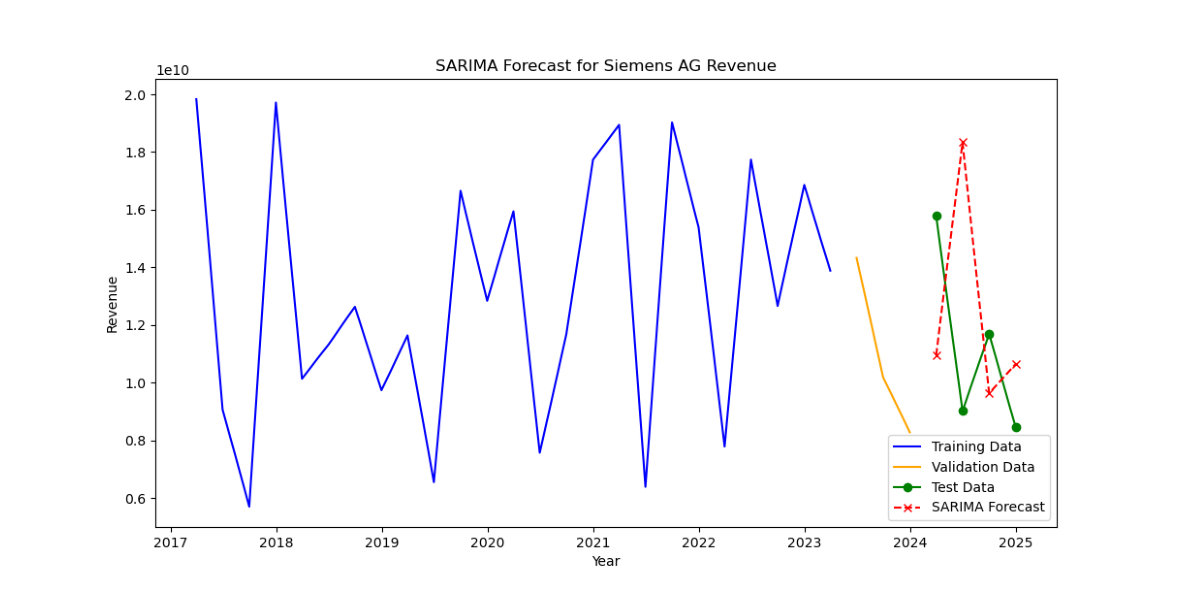

In [6]:
image, debug_message = forecast_turnover(horizon=4)

print(debug_message)  # Print debug info

if image is not None:
    #img = PIL.Image.open(image)  # ✅ Load the image from file path
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    plt.close()

In [7]:
a=b

NameError: name 'b' is not defined

In [ ]:
import gradio as gr
print(gr.__version__)
iface = gr.Interface(
    fn=forecast_turnover,
    inputs=gr.Slider(minimum=1, maximum=6, step=1, label="Forecast Horizon (Quarters)"),
    outputs=[gr.Image(type="numpy"), gr.Textbox()],  # ✅ Use 'type="pil"' for images
    title=f"{company} Revenue Forecast",
    description="Select the forecast horizon (in quarters) to generate revenue predictions.",
)

iface.launch(debug=True)

/opt/conda/envs/ai_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


5.20.0
* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
